In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.impute import SimpleImputer

In [6]:
boston = load_boston()
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
cross_val_score(regressor, boston.data, boston.target, cv=10, scoring="neg_mean_squared_error")

array([-11.22504076,  -5.3945749 ,  -4.74755867, -22.54699078,
       -12.31243335, -17.18030718,  -6.94019868, -94.14567212,
       -28.541145  , -14.6250416 ])

In [9]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

# 使用随即森林填补缺失值

In [11]:
dataset = load_boston()
dataset.data.shape
#总共506*13=6578个数据
X_full, y_full = dataset.data, dataset.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

添加缺失值

In [12]:
#首先确定我们希望放入的缺失数据的比例,在这里我们假设是50%,那总共就要有3289个数据缺失
rng = np.random.RandomState(0)
missing_rate = 0.5
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))
#np.floor向下取整,返回.0格式的浮点数

#所有数据要随机遍布在数据集的各行各列当中,而一个缺失的数据会需要一个行索引和一个列索引
#如果能够创造一个数组,包含3289个分布在0~506中间的行索引,和3289个分布在0~13之间的列索引,那我们就可
#以利用索引来为数据中的任意3289个位置赋空值
#然后我们用0,均值和随机森林来填写这些缺失值,然后查看回归的结果如何

missing_features = rng.randint(0,n_features,n_missing_samples)
missing_samples = rng.randint(0,n_samples,n_missing_samples)

#missing_samples = rng.choice(dataset.data.shape[0],n_missing_samples,replace=False)
#我们现在采样了3289个数据,远远超过我们的样本量506,所以我们使用随机抽取的函数randint。但如果我们需要
#的数据量小于我们的样本量506,那我们可以采用np.random.choice来抽样,choice会随机抽取不重复的随机数,
#因此可以帮助我们让数据更加分散,确保数据不会集中在一些行中

X_missing = X_full.copy()
y_missing = y_full.copy()

X_missing[missing_samples,missing_features] = np.nan
X_missing = pd.DataFrame(X_missing)
#转换成DataFrame是为了后续方便各种操作,numpy对矩阵的运算速度快到拯救人生,但是在索引等功能上却不如pandas

使用0和均值填充

In [13]:
#使用均值进行填补
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_missing_mean = imp_mean.fit_transform(X_missing)

#使用0进行填补
imp_0 = SimpleImputer(missing_values=np.nan, strategy="constant",fill_value=0)
X_missing_0 = imp_0.fit_transform(X_missing)

使用随即森林填充缺失值

In [14]:
"""
使用随机森林回归填补缺失值
任何回归都是从特征矩阵中学习,然后求解连续型标签y的过程,之所以能够实现这个过程,是因为回归算法认为,特征
矩阵和标签之前存在着某种联系。实际上,标签和特征是可以相互转换的,比如说,在一个“用地区,环境,附近学校数
量”预测“房价”的问题中,我们既可以用“地区”,“环境”,“附近学校数量”的数据来预测“房价”,也可以反过来,
用“环境”,“附近学校数量”和“房价”来预测“地区”。而回归填补缺失值,正是利用了这种思想。

对于一个有n个特征的数据来说,其中特征T有缺失值,我们就把特征T当作标签,其他的n-1个特征和原本的标签组成新
的特征矩阵。那对于T来说,它没有缺失的部分,就是我们的Y_test,这部分数据既有标签也有特征,而它缺失的部分,只有特征没有标签,就是我们需要预测的部分。


特征T不缺失的值对应的其他n-1个特征 + 本来的标签:X_train
特征T不缺失的值:Y_train

特征T缺失的值对应的其他n-1个特征 + 本来的标签:X_test
特征T缺失的值:未知,我们需要预测的Y_test

这种做法,对于某一个特征大量缺失,其他特征却很完整的情况,非常适用。

那如果数据中除了特征T之外,其他特征也有缺失值怎么办?
答案是遍历所有的特征,从缺失最少的开始进行填补(因为填补缺失最少的特征所需要的准确信息最少)。
填补一个特征时,先将其他特征的缺失值用0代替,每完成一次回归预测,就将预测值放到原本的特征矩阵中,再继续填
补下一个特征。每一次填补完毕,有缺失值的特征会减少一个,所以每次循环后,需要用0来填补的特征就越来越少。当
进行到最后一个特征时(这个特征应该是所有特征中缺失值最多的),已经没有任何的其他特征需要用0来进行填补了,
而我们已经使用回归为其他特征填补了大量有效信息,可以用来填补缺失最多的特征。
遍历所有的特征后,数据就完整,不再有缺失值了。
"""

X_missing_reg = X_missing.copy()
# 找出数据集中缺失值最多的从小到大的排序
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values

for i in sortindex:
    #构建我们的新特征矩阵和新标签
    df = X_missing_reg
    fillc = df.iloc[:,i]
    df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(y_full)],axis=1)
    #在新特征矩阵中,对含有缺失值的列,进行0的填补
    df_0 =SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0).fit_transform(df)
    #找出我们的训练集和测试集
    Ytrain = fillc[fillc.notnull()]
    Ytest = fillc[fillc.isnull()]
    Xtrain = df_0[Ytrain.index,:]
    Xtest = df_0[Ytest.index,:]
    #用随机森林回归来填补缺失值
    rfc = RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(Xtrain, Ytrain)
    Ypredict = rfc.predict(Xtest)
    #将填补好的特征返回到我们的原始的特征矩阵中
    X_missing_reg.loc[X_missing_reg.iloc[:,i].isnull(),i] = Ypredict

对填补好的数据进行建模

In [16]:
#对所有数据进行建模,取得MSE结果
X = [X_full,X_missing_mean,X_missing_0,X_missing_reg]
mse = []
std = []

for x in X:
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    scores = cross_val_score(estimator,x,y_full,scoring='neg_mean_squared_error',cv=5).mean()
    mse.append(scores * -1)

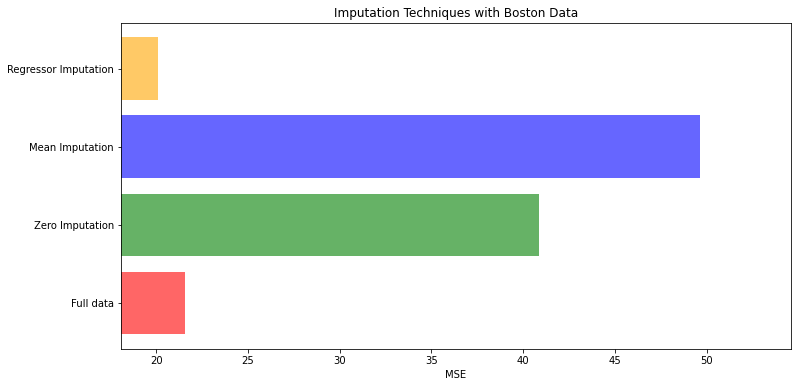

In [17]:
x_labels = ['Full data',
           'Zero Imputation',
           'Mean Imputation',
           'Regressor Imputation']
colors = ['r', 'g', 'b', 'orange']

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
for i in np.arange(len(mse)):
    ax.barh(i, mse[i],color=colors[i], alpha=0.6, align='center')
ax.set_title('Imputation Techniques with Boston Data')
ax.set_xlim(left=np.min(mse) * 0.9,
            right=np.max(mse) * 1.1)
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
ax.set_yticklabels(x_labels)
plt.show()